<a href="https://colab.research.google.com/github/leingang/Data-Science-For-Beginners/blob/main/covidspread_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment for Data Processing in Python

In this assignment, we will ask you to elaborate on the code we have started developing in our challenges. The assignment consists of two parts:

## COVID-19 Spread Modelling

 - [ ] Plot *R<sub>t</sub>* graphs for 5-6 different countries on one plot for comparison, or using several plots side-by-side
 - [ ] See how the number of deaths and recoveries correlate with number of infected cases.
 - [ ] Find out how long a typical disease lasts by visually correlating infection rate and deaths rate and looking for some anomalies. You may need to look at different countries to find that out.
 - [ ] Calculate the fatality rate and how it changes over time. *You may want to take into account the length of the disease in days to shift one time series before doing calculations*



### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/" # loading from Internet
# base_url = "../../data/COVID/" # loading from disk
infected_dataset_url = base_url + "time_series_covid19_confirmed_global.csv"
recovered_dataset_url = base_url + "time_series_covid19_recovered_global.csv"
deaths_dataset_url = base_url + "time_series_covid19_deaths_global.csv"
countries_dataset_url = base_url + "../UID_ISO_FIPS_LookUp_Table.csv"

In [3]:
infected = pd.read_csv(infected_dataset_url)
recovered = pd.read_csv(recovered_dataset_url)
deaths = pd.read_csv(deaths_dataset_url)
countries = pd.read_csv(countries_dataset_url)

Sum over countries to ignore regions. Also drop the lat/long of each.

TODO: Find a DRY-er way to do this.

In [4]:
infected = infected.groupby('Country/Region').sum()
recovered = recovered.groupby('Country/Region').sum()
deaths = deaths.groupby('Country/Region').sum()

infected.drop(columns=['Lat','Long'],inplace=True)
recovered.drop(columns=['Lat','Long'],inplace=True)
deaths.drop(columns=['Lat','Long'],inplace=True)


### $R_t$ by country

In [5]:
ninfectedt=infected.T.diff()
rt=ninfectedt.rolling(8).apply(lambda x: x[4:].sum()/x[:4].sum())
rt.index = pd.to_datetime(rt.index)

In [6]:
rt['US'][rt.index<"2020-05-01"]

2020-01-22         NaN
2020-01-23         NaN
2020-01-24         NaN
2020-01-25         NaN
2020-01-26         NaN
                ...   
2020-04-26    1.083912
2020-04-27    0.961824
2020-04-28    0.885074
2020-04-29    0.818168
2020-04-30    0.875529
Name: US, Length: 100, dtype: float64

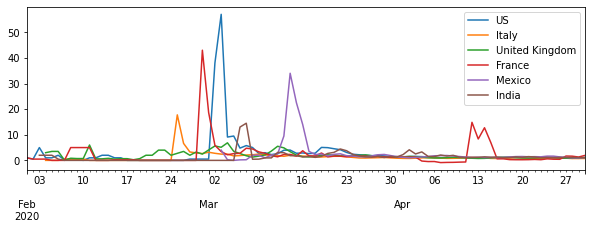

In [60]:
focus_countries = ['US','Italy','United Kingdom','France','Mexico','India']
for country in focus_countries:
  rt[country][(rt.index > "2020-01-31") & (rt.index<"2020-05-01")]\
    .replace(np.inf,np.nan).fillna(method='pad')\
    .plot(figsize=(10,3),legend=country)
plt.show()


### Deaths and Recoveries vs. Infections

In [36]:
stat_frames = {'infected':infected, 'recovered':recovered, 'deaths':deaths}
index = pd.MultiIndex.from_product([infected.index, stat_frames.keys()],names=['country','stat'])

In [42]:
df = pd.DataFrame(columns=index)
# FIXME: walking down an index is bad.
for (country,stat) in index:
  df[(country,stat)] = stat_frames[stat].loc[country]
df.index = pd.to_datetime(df.index)
# This doesn't work
# df.loc[:,(slice(None),'infected')] = infected.T
# df

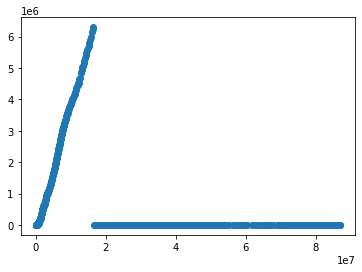

In [44]:
plt.scatter(df['US','infected'],df['US','recovered'])

The problem is that recoveries are not reported after a certain time point.  We could clean the data to null out zeroes that follow a positive number, or just skip all rows with a zero for recoveries.

In [56]:
# works!
df['US'][df['US','recovered'] > 0]

stat,infected,recovered,deaths
2020-02-09,12,3,0
2020-02-10,12,3,0
2020-02-11,13,3,0
2020-02-12,13,3,0
2020-02-13,14,3,0
...,...,...,...
2020-12-09,15516739,5889896,292047
2020-12-10,15753683,5985047,295036
2020-12-11,15992585,6135314,298393
2020-12-12,16217120,6246605,300912


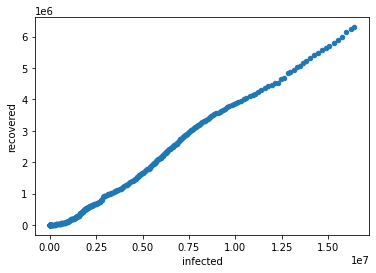

In [59]:
df['US'][df['US','recovered'] > 0].plot(kind='scatter',x='infected',y='recovered')

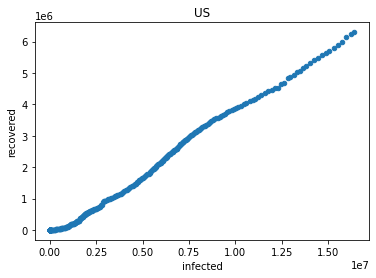

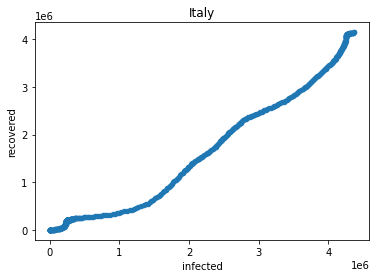

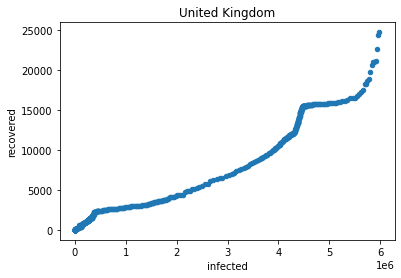

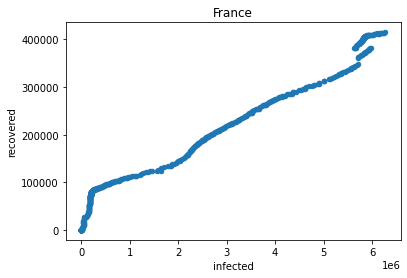

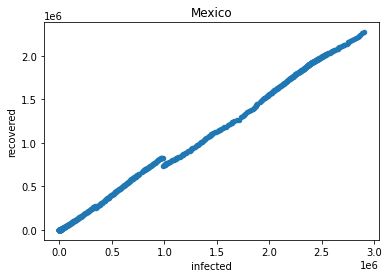

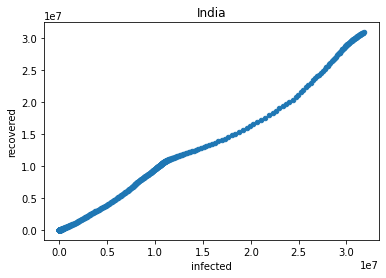

In [68]:
for country in focus_countries:
  df[country][df[country,'recovered'] > 0]\
    .plot(kind='scatter',x='infected',y='recovered',title=country)

In [69]:
df['US'][df['US','recovered'] > 0].corr()

stat,infected,recovered,deaths
stat,,,
infected,1.000000,0.997033,0.942283
recovered,0.997033,1.000000,0.927651
deaths,0.942283,0.927651,1.000000


In [77]:
for country in focus_countries:
  print("{}:\n".format(country))
  print(df[country][df[country,'recovered'] > 0].corr())
  print("\n")

US:

stat       infected  recovered    deaths
stat                                    
infected   1.000000   0.997033  0.942283
recovered  0.997033   1.000000  0.927651
deaths     0.942283   0.927651  1.000000


Italy:

stat       infected  recovered    deaths
stat                                    
infected   1.000000   0.989472  0.986017
recovered  0.989472   1.000000  0.978232
deaths     0.986017   0.978232  1.000000


United Kingdom:

stat       infected  recovered    deaths
stat                                    
infected   1.000000   0.981769  0.971257
recovered  0.981769   1.000000  0.958361
deaths     0.971257   0.958361  1.000000


France:

stat       infected  recovered    deaths
stat                                    
infected   1.000000   0.988292  0.978801
recovered  0.988292   1.000000  0.992167
deaths     0.978801   0.992167  1.000000


Mexico:

stat       infected  recovered    deaths
stat                                    
infected   1.000000   0.999174  0.997741
r

Strong correlation, obviously

### Correlation of death rate to infection rate

I want to add the infection rate and death rate to the main dataframe, smartly.

In [103]:
index.unique(level="country")

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antarctica',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       ...
       'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam',
       'West Bank and Gaza', 'Winter Olympics 2022', 'Yemen', 'Zambia',
       'Zimbabwe'],
      dtype='object', name='country', length=199)

In [123]:
ndf=pd.DataFrame(
    index=df.index,
    columns=pd.MultiIndex.from_product(
        [df.columns.unique(level="country"),
        ["ninfected","ndeaths"]],
        names=["country","stat"]
    ))
ndf = ndf.swaplevel(axis="columns")
ndf['ninfected'] = df.swaplevel(axis="columns")['infected'].diff()
ndf['ndeaths'] = df.swaplevel(axis="columns")['deaths'].diff()
ndf = ndf.swaplevel(axis="columns")
df = df.join(ndf)

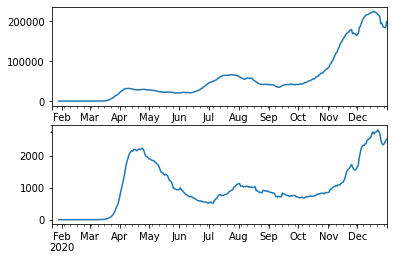

In [143]:
fig,axs = plt.subplots(2)
for i,stat in enumerate(['ninfected','ndeaths']):
  df['US',stat]\
    [df.index < "2021-01-01"]\
    .rolling(window=7).mean()\
    .plot(ax=axs[i])
fig.show()

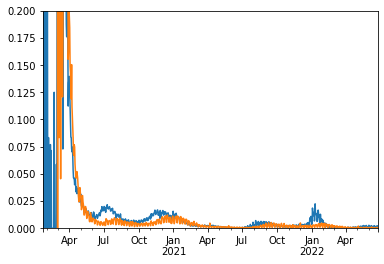

In [147]:
(df['US','ninfected']/df['US','infected']).plot()
(df['US','ndeaths']/df['US','deaths']).plot()
plt.ylim(0,0.2)
plt.show()

You can finally see a lag between %infected and %deaths

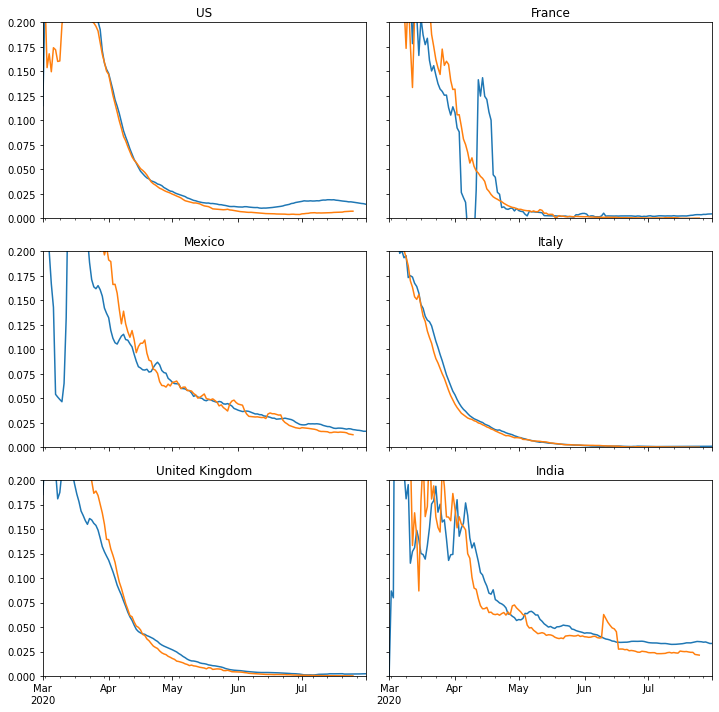

In [214]:
fig, axs = plt.subplots(3,2,sharex=True,sharey=True)
fig.set_size_inches(10,10)
for i,country in enumerate(focus_countries):
  ax = axs[i%3,i%2]
  for stat,shift in [('infected',0),('deaths',6)]:
    (df[country,"n" + stat].rolling(window=7).mean()/
    df[country,stat].rolling(window=7).mean())\
      [(df.index >= "2020-03-01") & (df.index <= "2020-07-31")]\
      .shift(periods=-shift)\
      .plot(ax=ax)
    ax.set_ylim(0,0.2)
    ax.set_title(country)
fig.tight_layout()
fig.show()

Can we find the time shift which minimizes the distance between the curves?

In [211]:
dists = pd.DataFrame(index=range(30),columns=focus_countries)
for country in dists.columns:
  d1 = df[country,"ninfected"].rolling(window=7).mean()/df[country,"infected"].rolling(window=7).mean()
  d2 = df[country,"ndeaths"].rolling(window=7).mean()/df[country,"deaths"].rolling(window=7).mean()
  for i in dists.index:  
    dists.loc[i,country] = np.linalg.norm((d1-d2.shift(periods=i)).dropna())
dists

,US,Italy,United Kingdom,France,Mexico,India
0,1.225247,0.662367,1.118526,1.410764,0.985459,1.079376
1,1.144232,0.555291,1.147547,1.43859,1.029551,1.070904
2,1.045551,0.623453,1.17034,1.467228,1.059926,1.073687
3,1.004287,0.769957,1.169836,1.500591,1.086432,1.068655
4,0.995561,0.868988,1.163024,1.53921,1.122307,1.078481
5,0.971232,0.936333,1.160088,1.567385,1.147052,1.088113
6,1.025364,0.988476,1.176714,1.580921,1.162572,1.083523
7,1.047155,1.049347,1.211185,1.585894,1.173508,1.07626
8,1.096194,1.101318,1.248976,1.565408,1.184059,1.053009
9,1.1391,1.133307,1.279623,1.54172,1.200434,1.030664


In [226]:
[np.array(dists[c]).argmin() for c in dists.columns]

[5, 1, 0, 14, 0, 10]

Not that convincing. Maybe try an ordinary correlation?

In [254]:
corrs = pd.DataFrame(
    index=pd.Index(range(30),name="days"),
    columns=df.columns.unique(level="country"))
for country in corrs.columns:
  d1 = df[country,"ninfected"].rolling(window=7).mean()
  d2 = df[country,"ndeaths"].rolling(window=7).mean()
  for i in dists.index:  
    corrs.loc[i,country] = d1.corr(d2.shift(periods=-i))
corrs.dropna(axis=1,inplace=True)
corrs

country,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
days,,,,,,,,,,,,,,,,,,,,,
0,0.900041,0.628451,0.654604,0.112316,0.512038,0.530276,0.327009,0.659523,0.77348,0.176305,...,0.123399,0.49843,0.838614,0.428355,0.819798,0.165871,0.650524,0.876012,0.66998,0.575311
1,0.90707,0.636198,0.664646,0.103853,0.513481,0.50638,0.336645,0.678037,0.789004,0.18308,...,0.133421,0.50478,0.839233,0.440257,0.813398,0.161809,0.646672,0.879955,0.681498,0.590244
2,0.913959,0.644678,0.673419,0.101811,0.515937,0.493991,0.346218,0.696001,0.804089,0.189619,...,0.140392,0.510943,0.839616,0.467139,0.814238,0.157779,0.642343,0.880432,0.691134,0.605329
3,0.919658,0.651519,0.680907,0.104622,0.518573,0.485296,0.355632,0.713172,0.818552,0.195854,...,0.14621,0.516488,0.839278,0.485665,0.817142,0.153579,0.638992,0.875533,0.698986,0.619486
4,0.924646,0.657642,0.68726,0.10915,0.521069,0.482591,0.364705,0.72934,0.832682,0.201752,...,0.151615,0.521496,0.838116,0.512148,0.816961,0.14936,0.635392,0.867268,0.705402,0.631567
5,0.928353,0.662813,0.692337,0.110567,0.523803,0.487632,0.37371,0.744441,0.845744,0.207255,...,0.156684,0.525911,0.836475,0.547009,0.819734,0.145117,0.631839,0.859132,0.70981,0.641922
6,0.931546,0.667272,0.69637,0.108344,0.526345,0.476496,0.38227,0.758271,0.856976,0.21228,...,0.161136,0.529654,0.834174,0.58676,0.818813,0.140556,0.62491,0.850182,0.712186,0.65023
7,0.934377,0.670716,0.699375,0.105764,0.526858,0.453154,0.390186,0.770517,0.867502,0.216845,...,0.1651,0.532537,0.830828,0.628196,0.815193,0.135845,0.615488,0.843534,0.712573,0.65641
8,0.93765,0.674647,0.701319,0.113945,0.528741,0.457607,0.397627,0.781295,0.877613,0.220867,...,0.168586,0.53495,0.827877,0.633467,0.819929,0.131013,0.622953,0.843516,0.711078,0.662159


The index of the maximum element in each column is the number of days the (smoothed) `ndeaths` column most closely lags behind the (smoothed) `ninfected` column.

In [255]:
shifts = corrs.apply(lambda x: np.array(x).argmax())
shifts

country
Afghanistan            9
Albania               12
Algeria                9
Andorra               10
Angola                 8
                      ..
Vietnam                0
West Bank and Gaza     0
Yemen                  2
Zambia                 7
Zimbabwe               9
Length: 193, dtype: int64

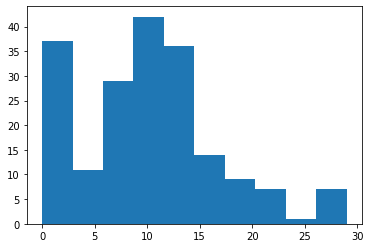

In [267]:
plt.hist(shifts)
plt.show()

The `0` values are the columns where the correlation is largest at the beginning, and the `29`s are when it's largest at the end.

Average shift: 11.329032258064515


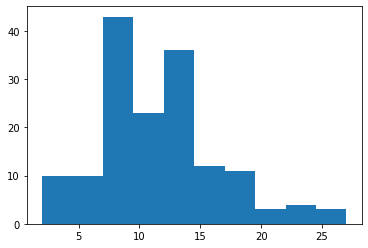

In [266]:
print("Average shift: {}".format(shifts[(shifts > 0) & (shifts < 29)].mean()))
plt.hist(shifts[(shifts > 0) & (shifts < 29)])
plt.show()

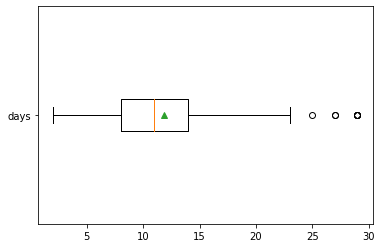

In [272]:
plt.boxplot(shifts[shifts>0],vert=False,showmeans=True,labels=["days"])
plt.show()

We estimate a 11-12 day length of disease.

### Fatality Rate

We're looking for the fraction of people diagnosed who die from it. We'll shift the deaths by 12 days to account for the disease's length

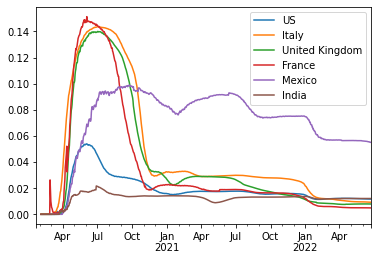

In [282]:
for c in focus_countries:
  (df[c,'deaths'].shift(periods=12)/df[c,'infected']).plot()
plt.legend(focus_countries)
plt.show()
